## Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os

from keras.layers import Input  
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

## Load the dataset and data exploratory

In [3]:
path = os.listdir("D:/StatoilC-CORE Iceberg Classifier Challenge/")
print(path)

['sample_submission.csv', 'test.json', 'train.json']


In [4]:
#Load dataset
df_train = pd.read_json("D:/StatoilC-CORE Iceberg Classifier Challenge/train.json/train.json")
df_train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
print(df_train.shape)

(1604, 5)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB


In [7]:
# MISSING VALUES:
#NOTE: we want to find "Nan" filds and replace it
df_train.inc_angle.replace({"na":np.nan}, inplace=True)
# Drop the rows that has NaN value for inc_angle
df_train.drop(df_train[df_train["inc_angle"].isnull()].index, inplace=True)

In [8]:
df_train["is_iceberg"].describe()

count    1471.000000
mean        0.511897
std         0.500028
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: is_iceberg, dtype: float64

C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_iceberg', ylabel='count'>

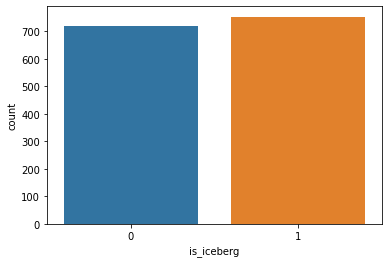

In [9]:
sns.countplot(df_train["is_iceberg"])

In [10]:
df_train["is_iceberg"].value_counts()

1    753
0    718
Name: is_iceberg, dtype: int64

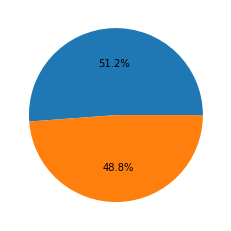

In [11]:
iceberg_size = df_train["is_iceberg"].value_counts(sort=1)
plt.pie(iceberg_size, autopct = "%1.1f%%")
plt.show()

C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='is_iceberg', ylabel='Density'>

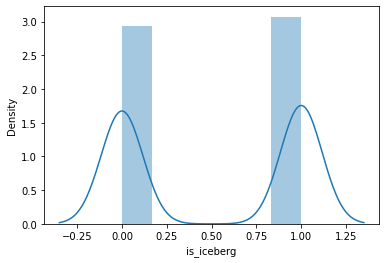

In [12]:
sns.distplot(df_train["is_iceberg"])

In [13]:
def prepare_data(df):
    X_band_1 = []
    X_band_2 = []
    
    for band in df["band_1"]:
        #Convert to float32
        band_1 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_1 = band_1.reshape(75,75)
        X_band_1.append(band_1)
        
    for band in df["band_2"]:
         #Convert to float32
        band_2 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_2 = band_2.reshape(75,75)
        X_band_2.append(band_2)
        
    #Convert list to numpy array
    X_band_1 = np.array(X_band_1)
    X_band_2 = np.array(X_band_2)
    
    # Rescale
    X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
    X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
    #Concatenate band_1 and band_2 to create X for training (or test)
    X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                        X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                        axis=-1)
    
    Y = np.array(df["is_iceberg"])
    
    return X, Y

In [14]:
X, Y = prepare_data(df_train)

print("X shape is:{}".format(X.shape))
print("Y shape is:{}".format(Y.shape))

X shape is:(1471, 75, 75, 3)
Y shape is:(1471,)


In [15]:
#Split data to test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X_train shape = {}".format(X_train.shape))
print("X_test shape = {}".format(X_test.shape))
print("Y_train shape = {}".format(Y_train.shape))
print("Y_test shape = {}".format(Y_test.shape))

X_train shape = (1176, 75, 75, 3)
X_test shape = (295, 75, 75, 3)
Y_train shape = (1176,)
Y_test shape = (295,)


# CNN Tensorflow

In [16]:
# number of classes
k = len(set(Y_train))
print("Number of classes: {}".format(k))

Number of classes: 2


In [17]:
def FCN_model(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS):
    
    inputs = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
    
    # Build the model
    model = Sequential()
    
    # Conv 1
    model.add(Conv2D(64, kernel_size=(3,3), input_shape=inputs))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    # Conv 2
    model.add(Conv2D(128, kernel_size=(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    # Conv 3
    model.add(Conv2D(128, kernel_size=(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    # Conv 4
    model.add(Conv2D(64, kernel_size=(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    # Flatten layer
    model.add(Flatten())
    
    # Dense layer 1
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    
    # Dense layer 2
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    # Compile the model
    model.compile(loss = "binary_crossentropy", 
                  optimizer = "adam",
                  metrics = ["accuracy"])
    model.summary()
    
    return model

In [18]:
# Build FCN model
IMAGE_WIDTH = 75
IMAGE_HEIGHT = 75
IMAGE_CHANNELS = 3
batch_size = 32


fcn_model = FCN_model(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 73, 73, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 34, 34, 128)       0         
_________________________

In [20]:
# Fit the model
history = fcn_model.fit(X_train, Y_train, 
                        validation_data = (X_test, Y_test), 
                        epochs = 10, 
                        batch_size = batch_size,
                        shuffle = True)

Train on 1176 samples, validate on 295 samples
Epoch 1/10
1176/1176 [==============================] - 131s 112ms/step - loss: 0.2620 - accuracy: 0.8852 - val_loss: 0.3006 - val_accuracy: 0.8881
Epoch 2/10
1176/1176 [==============================] - 136s 116ms/step - loss: 0.2778 - accuracy: 0.8750 - val_loss: 0.2400 - val_accuracy: 0.9119
Epoch 3/10
1176/1176 [==============================] - 143s 122ms/step - loss: 0.2208 - accuracy: 0.9175 - val_loss: 0.2952 - val_accuracy: 0.8915
Epoch 4/10
1176/1176 [==============================] - 152s 129ms/step - loss: 0.2059 - accuracy: 0.9141 - val_loss: 0.2322 - val_accuracy: 0.9119
Epoch 5/10
1176/1176 [==============================] - 159s 135ms/step - loss: 0.2154 - accuracy: 0.9150 - val_loss: 0.2179 - val_accuracy: 0.9119
Epoch 6/10
1176/1176 [==============================] - 137s 117ms/step - loss: 0.1820 - accuracy: 0.9277 - val_loss: 0.2724 - val_accuracy: 0.9085
Epoch 7/10
1176/1176 [==============================] - 153s 130m

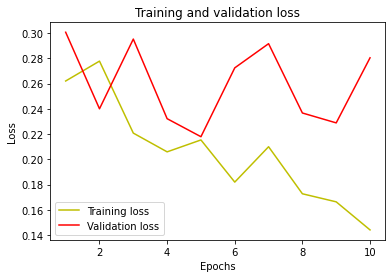

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

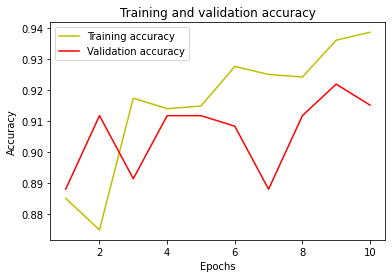

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# Evaluate model
test_loss, test_acc = fcn_model.evaluate(X_test, Y_test, verbose=1)
print("Test Score = ", test_loss)
print("Test Accuracy = ", test_acc)

295/295 [==============================] - 10s 33ms/step
Test Score =  0.2804032484985004
Test Accuracy =  0.9152542352676392


# Model Metrics

Three metrics to evaluate the classification accuracy of neural network, which are being used commonly, incldue:

1- Precision

2- Recall

3- F1 Score

In [25]:
# Evaluate augmnented model result

# Predict the probability
y_p = fcn_model.predict(X_test, verbose=0).argmax(axis=1)

# Predict each class
y_classes = fcn_model.predict_classes(X_test, verbose=0)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_p))

              precision    recall  f1-score   support

           0       0.47      1.00      0.64       139
           1       0.00      0.00      0.00       156

    accuracy                           0.47       295
   macro avg       0.24      0.50      0.32       295
weighted avg       0.22      0.47      0.30       295



C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
def cal_accuracy(predictions, y_classes):
    
    # precision tp / (tp + fp)
    # 'average' parameter is required for multiclass/multilabel targets
    precision = precision_score(predictions, y_classes, average='weighted')
    print('Precision score is : {}'.format(precision))
    
    # recall: tp / (tp + fn)
    recall = recall_score(predictions, y_classes, average='weighted')
    print('Recall score is : {}'.format(recall))
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(predictions, y_classes, average='weighted')
    print('f1 score is : {}'.format(f1))
    
    return precision, recall, f1

In [28]:
metrics = cal_accuracy(y_p, y_classes) 
print(metrics)

Precision score is : 1.0
Recall score is : 0.4271186440677966
f1 score is : 0.5985748218527316
(1.0, 0.4271186440677966, 0.5985748218527316)


C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
